# A Cognitive Model or Harmonic Types (Simplified Amortization)

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Thesis/probabilistic_harmony_model

Mounted at /content/drive
/content/drive/MyDrive/Thesis/probabilistic_harmony_model


In [2]:
!pip install pyro-api==0.1.2
!pip install pyro-ppl==1.8.4
!pip install pitchtypes==0.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 kB 8.8 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

from pyro.distributions import *
#from collections import Counter
import pyro.infer
import pyro.optim
import pyro.util
pyro.enable_validation(True)

import matplotlib.pyplot as plt
import tqdm

import numpy as np
import pandas as pd
import scipy.stats as stats

import os.path as path
from datetime import datetime
import json

import utils

import gc

In [4]:
gpu = torch.cuda.is_available()

gpu_n = 0

torch.set_default_dtype(torch.float32)

torch.autograd.set_detect_anomaly(True)

device = torch.device(f'cuda:{gpu_n}' if gpu else 'cpu')
print(device)

cuda:0


In [5]:
def save_rng_state(name):
    fn = name + '-' + datetime.today().isoformat() + '.state'
    state = pyro.util.get_rng_state()
    with open('rng-' + fn, 'w') as f:
        print(state, file=f)
    torch.save(state['torch'], 'torch-' + fn)

In [6]:
# set random seeds
pyro.set_rng_seed(0)
#torch.set_deterministic(True)
#torch.set_num_threads(1)
#torch.set_num_interop_threads(1)

# fix the range of pitches we consider
fifth_range = 2*7                  # 2 diatonics
npcs = 2*fifth_range+1             # around C: Cbb to C## on LoF
utils.set_fifth_range(fifth_range) # used to make helper functions work correctly

# **1. Amortization**



## Step 1: Model

**Notations:**
- $h$: probablity distribution of chords (harmony)
- $\Phi$: chord profile for all chord types, where each $\phi_i$ conntains weights for each chord
- $npcs$: range of line of fifths, which is the number of pitches we consider
- $n_{harmonies}$: number of different chord types
- $n_{chords}$: length of dataset (how many chords we observe in the dataset)

**Generating Process:**

For all $i$:

- $\phi_i \sim Dirichlet(0.5, npcs)$
- $h \sim Dirichlet(0.5, n_{harmonies})$

    For each chord j:
    - Choose chords: $c_i \sim Categorical(h)$
    - Choose pitches: $p_j \sim Multinomial(\phi_{cj}, N_j)$

where $p_j$ and $N_j$ are observed, other variables are unobserved.

In [7]:
def simplified_chord_model(npcs, nharmonies, data, subsamples=500, **kwargs):
    # parameters priors:
    # distribution of the harmonies
    p_harmony = pyro.sample('p_harmony', dist.Dirichlet(0.8 * torch.ones(nharmonies, device=device) + 1e-3))
    # distribution of notes in the harmonies (chord profiles)
    with pyro.plate('harmonies', nharmonies):
        chord_profiles = pyro.sample('chord_profiles', dist.Dirichlet(0.8 * torch.ones(npcs, device=device) + 1e-3))

    # Sampling the data:
    nchords = len(data['c'])
    subs = torch.arange(min(nchords, subsamples), device=device) if subsamples is not None else torch.arange(nchords, device=device)

    with pyro.plate('data', nchords, subsample=subs) as ind:
        # sample a chord type based on the harmony distribution (to be inferred)
        c = pyro.sample('c', dist.Categorical(p_harmony))

        # sampling pitches for the chord based on the selected chord type profile
        pitches = pyro.sample('pitches', dist.Multinomial(1, probs=chord_profiles[c], validate_args=False), obs=data['pitches'][ind])

    return {"p_harmony": p_harmony, "chord_profiles": chord_profiles, "c": c, "pitches": pitches}

## Step 2: Amortization Guide for Inference


In [8]:
# simpler
class AmortizationNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x.float()))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

In [9]:
# # with regulation
# class AmortizationNetwork(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super().__init__()
#         self.fc1 = nn.Linear(input_dim, hidden_dim)
#         self.fc2 = nn.Linear(hidden_dim, output_dim)
#         self.dropout = nn.Dropout(p=0.5)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x.float()))
#         x = self.dropout(x)
#         x = torch.softmax(self.fc2(x), dim=-1)
#         return x

In [10]:
# # more complex
# class AmortizationNetwork(nn.Module):
#     def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
#         super().__init__()
#         self.fc1 = nn.Linear(input_dim, hidden_dim1)
#         self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
#         self.fc3 = nn.Linear(hidden_dim2, output_dim)
#         # self.dropout = nn.Dropout(p=0.5)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x.float()))
#         # x = self.dropout(x)
#         x = torch.softmax(self.fc3(x), dim=-1)
#         return x

In [11]:
def amortization_guide(npcs, nharmonies, data, subsamples=500, **kwargs):
    # for the distribution of the harmonies
    # initialize alpha parameters with more information, assuming some harmonies might be more probable
    alpha_h = pyro.param('alpha_h', (torch.ones(nharmonies, device=device) * 0.8 + 1e-3), constraint=constraints.positive)

    pyro.sample('p_harmony', dist.Dirichlet(alpha_h))

    # for the chord profiles
    with pyro.plate('harmonies', nharmonies):
        alpha_phi = pyro.param('alpha_phi', (torch.ones([nharmonies, npcs], device=device) * 0.8 + 1e-3), constraint=constraints.positive)
        pyro.sample('chord_profiles', dist.Dirichlet(alpha_phi))

    # for chord types
    net = AmortizationNetwork(input_dim=npcs, hidden_dim=128, output_dim=nharmonies)
    # net = AmortizationNetwork(input_dim=npcs, hidden_dim1=128, hidden_dim2=64, output_dim=nharmonies)
    net.to(device)
    pyro.module("net", net)

    nchords = len(data['c'])
    subs = torch.arange(min(nchords, subsamples), device=device) if subsamples is not None else torch.arange(nchords, device=device)

    with pyro.plate('data', nchords, subsample=subs) as ind:
        # Use NN to predict parameters for the chord types
        chord_features = data['pitches']
        chord_type_params = net(chord_features[ind])
        pyro.sample('c', dist.Categorical(probs=chord_type_params))

## Step 3: Data and Conditioning
**Data Format**


In [12]:
def to_device_and_dtype(tensor, device):
    return tensor.to(device).float()

In [13]:
def simplified_chord_tensor(notes):
    """Takes a list of fifths and returns a vector of counts for fifths."""
    #chord = torch.zeros(npcs, device=device)
    chord = torch.zeros(npcs).float()
    for fifth in notes:
        index = utils.fifth_to_index(fifth)
        chord[index] += 1
    #return chord
    return to_device_and_dtype(chord, device)

def simplified_annot_data_obs(chords):
    """Helper function to turn a list of chord dictionaries into a dictionary of observation vectors."""
    obs = {}
    obs["pitches"] = torch.cat([simplified_chord_tensor(c['notes']).reshape((1, -1)) for c in chords], dim=0)
    #obs["c"] = torch.tensor([c['label'] for c in chords], device=device)
    #obs["n"] = torch.tensor([len(c['notes']) - 1 for c in chords], device=device)
    #return obs
    obs["c"] = torch.tensor([c['label'] for c in chords]).long()
    obs["n"] = torch.tensor([len(c['notes']) - 1 for c in chords]).long()
    return {k: to_device_and_dtype(v, device) for k, v in obs.items()}

**Loading the Dataset**

The data is loaded from a TSV file that. The resulting dataframe is converted to the observation format that we pass to the model.

In [14]:
def load_dataset(filename):
    filename = path.join("data", filename)
    print("loading dataset...")
    df = utils.load_csv(filename)
    sizes = df.groupby(['chordid', 'label']).size()
    type_counts = sizes.groupby('label').size().sort_values(ascending=False)
    chordtypes = type_counts.index.tolist()
    df['numlabel'] = df.label.map(chordtypes.index)

    # check if precomputed tensor data is available:
    prefn = filename + "_precomp.pt"
    if path.exists(prefn) and path.getmtime(prefn) > path.getmtime(filename):
        print("using precomputed tensor data.")
        obs = torch.load(prefn, map_location=device)
    else:
        print('extracting chords...')
        chords = [{'label': numlabel, 'notes': [row['fifth'] for index, row in grp.iterrows()]}
                  for (_, numlabel), grp in tqdm.tqdm(df.groupby(['chordid', 'numlabel']))]
        print('converting chords to tensors...')
        obs = simplified_annot_data_obs(chords)
        torch.save(obs, prefn)

    print(len(chordtypes), "chord types")
    print(len(obs["c"]), "chords")
    return df, obs, chordtypes

In [15]:
def get_init_params(df, nharms, npcs):
    init = dict()

    # initialize params for harmonies
    init['harmonies'] = torch.tensor(df.groupby('numlabel').size().sort_values(ascending=False), device=device) + 0.5

    # initialize params for chord profiles
    init['chord_profiles'] = torch.zeros([nharms, npcs], device=device) + 0.5
    for (numlabel, fifth), grp in df.groupby(['numlabel', 'fifth']):
        init['chord_profiles'][numlabel, utils.fifth_to_index(fifth)] += grp.fifth.count()

    chord_sizes = df.groupby('chordid').size()
    init['sum_chords'] = torch.tensor(sum(chord_sizes), device=device)
    init['n_chords'] = torch.tensor(len(chord_sizes), device=device)
    return init

After inferring the parameters we save them for easier inspection and reuse.



In [16]:
def save_params(params, nharmonies, npcs, name):
    # Save the PyTorch parameters
    torch.save(params , path.join("results", name + '.pt'))

    # Save the parameters in a JSON file for easy access
    with open(path.join("results", name + '.json'), 'w') as f:
        json.dump({'params': {key: val.tolist() for key, val in params.items()},
                   'nharmonies': nharmonies,
                   'npcs': npcs},
                  f)

## Step 4: Inference

In [17]:
def infer_amortized_posteriors(npcs, nharmonies, data, nsteps=5000, lr=0.01, step_size=100, clip_grad=0.1, plot_loss=True, save_as=None, collect_history=False):
    pyro.clear_param_store()
    pyro.set_rng_seed(1625)

    svi = pyro.infer.SVI(model=simplified_chord_model,
                         guide=lambda npcs, nharmonies, data: amortization_guide(npcs, nharmonies, data),
                         optim=pyro.optim.Adam({"lr": lr, "betas": (0.95, 0.999)}),
                         loss=pyro.infer.Trace_ELBO())

    losses = []
    alpha_h_history = []
    alpha_phi_history = []

    for step in tqdm.trange(nsteps):
        loss = svi.step(npcs, nharmonies, data)

        # check for NaNs and infs in gradients
        for name, param in pyro.get_param_store().items():
            if param.grad is not None:
                if torch.isnan(param.grad).any() or torch.isinf(param.grad).any():
                    raise ValueError(f'Gradient for {name} has NaN/inf values.')

        # clip gradients
        for p in pyro.get_param_store().values():
            p.register_hook(lambda grad: torch.clamp(grad, -clip_grad, clip_grad))

        losses.append(loss)

        if collect_history:
            # collect parameter histories
            alpha_h_history.append(pyro.param('alpha_h').detach().cpu().numpy())
            alpha_phi_history.append(pyro.param('alpha_phi').detach().cpu().numpy())

        if step % 100 == 0:
            print(f"Step {step} : loss = {loss}")

    # plot the loss
    if plot_loss:
        plt.figure(figsize=(12, 5))
        plt.plot(losses)
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.title(f"SVI Convergence ({save_as})")
        plt.show()

    # save inferred parameters
    params = {name: value.detach().cpu().numpy() for name, value in pyro.get_param_store().items()}

    if save_as is not None:
        save_params(params, nharmonies, npcs, save_as)

    return params, (alpha_h_history, alpha_phi_history) if collect_history else params

## Step 5: Plotting

In [18]:
def plot_param_histories(alpha_h_history, alpha_phi_history):
    # Plot alpha_h history
    plt.figure(figsize=(12, 5))
    plt.plot(alpha_h_history)
    plt.title('Alpha_h parameter history')
    plt.xlabel('Iteration')
    plt.ylabel('Alpha_h values')
    plt.show()

    # Plot alpha_phi history (for simplicity, here we just plot the mean over the pitch classes)
    alpha_phi_mean_history = np.mean(alpha_phi_history, axis=-1)  # Compute the mean over pitch classes
    plt.figure(figsize=(12, 5))
    plt.plot(alpha_phi_mean_history)
    plt.title('Mean Alpha_phi parameter history')
    plt.xlabel('Iteration')
    plt.ylabel('Mean Alpha_phi values')
    plt.show()

In [19]:
def plot_amortized_inference_results(params, nharmonies, npcs, save_as=None):
    # Extract harmony and chord profile parameters
    harmony_params = params['alpha_h']
    chord_profile_params = params['alpha_phi']

    # Normalize the parameters
    harmony_normalized = harmony_params / np.sum(harmony_params)
    chord_profile_normalized = np.array([cp / np.sum(cp) for cp in chord_profile_params])

    num_subplots = nharmonies + 1

    fig, axs = plt.subplots(num_subplots, 1, figsize=(12, 3 * num_subplots))

    # Plot harmony distribution
    axs[0].bar(np.arange(len(harmony_normalized)), harmony_normalized)
    axs[0].set_title('Harmony Distribution')
    axs[0].set_xlabel('Harmony Types')
    axs[0].set_ylabel('Probability')

    # Plot chord profile parameters for each harmony
    for i in range(nharmonies):
        axs[i + 1].bar(np.arange(npcs), chord_profile_normalized[i])
        axs[i + 1].set_title(f'Chord Profile for Harmony {i}')
        axs[i + 1].set_xlabel('Pitches')
        axs[i + 1].set_ylabel('Probability')

    plt.tight_layout()
    if save_as:
        plt.savefig(f"{save_as}.png")
    plt.show()

# **2. Experiment**

In [20]:
dcml_df, dcml_obs, dcml_chordtypes = load_dataset('dcml.tsv')
dcml_init = get_init_params(dcml_df, len(dcml_chordtypes), npcs)

loading dataset...
using precomputed tensor data.
14 chord types
113771 chords


  0%|          | 0/50000 [00:00<?, ?it/s]<ipython-input-17-24b1f9ee624c>:19: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  if param.grad is not None:
  0%|          | 1/50000 [00:06<88:42:25,  6.39s/it]

Step 0 : loss = 3648307.1444222257


  0%|          | 102/50000 [00:25<1:48:35,  7.66it/s]

Step 100 : loss = 2965857.7151705986


  0%|          | 201/50000 [00:36<1:20:28, 10.31it/s]

Step 200 : loss = 2616619.331421943


  1%|          | 302/50000 [00:47<1:24:46,  9.77it/s]

Step 300 : loss = 2279849.3943936955


  1%|          | 402/50000 [00:58<1:37:01,  8.52it/s]

Step 400 : loss = 2200279.7806499335


  1%|          | 502/50000 [01:08<1:38:51,  8.34it/s]

Step 500 : loss = 2103524.7258376786


  1%|          | 602/50000 [01:19<1:23:19,  9.88it/s]

Step 600 : loss = 2029298.5052696234


  1%|▏         | 703/50000 [01:31<1:22:36,  9.95it/s]

Step 700 : loss = 2042058.877051265


  2%|▏         | 802/50000 [01:42<1:49:14,  7.51it/s]

Step 800 : loss = 1961467.7801887542


  2%|▏         | 902/50000 [01:54<3:52:15,  3.52it/s]

Step 900 : loss = 2012517.2655271953


  2%|▏         | 1002/50000 [02:05<1:20:51, 10.10it/s]

Step 1000 : loss = 1978935.018667766


  2%|▏         | 1102/50000 [02:16<1:22:48,  9.84it/s]

Step 1100 : loss = 1951244.864513475


  2%|▏         | 1203/50000 [02:27<1:22:36,  9.85it/s]

Step 1200 : loss = 1930292.4357107375


  3%|▎         | 1302/50000 [02:38<1:45:04,  7.72it/s]

Step 1300 : loss = 1902702.3161390172


  3%|▎         | 1402/50000 [02:49<1:25:24,  9.48it/s]

Step 1400 : loss = 1863231.961468961


  3%|▎         | 1502/50000 [03:00<1:27:57,  9.19it/s]

Step 1500 : loss = 1884528.2773853694


  3%|▎         | 1603/50000 [03:12<1:20:41, 10.00it/s]

Step 1600 : loss = 1912804.1035353672


  3%|▎         | 1702/50000 [03:22<1:43:36,  7.77it/s]

Step 1700 : loss = 1863225.2537675463


  4%|▎         | 1802/50000 [03:33<1:24:16,  9.53it/s]

Step 1800 : loss = 1862202.8845509281


  4%|▍         | 1903/50000 [03:45<1:20:13,  9.99it/s]

Step 1900 : loss = 1879229.6862700363


  4%|▍         | 2002/50000 [03:56<1:24:05,  9.51it/s]

Step 2000 : loss = 1864546.7025380442


  4%|▍         | 2102/50000 [04:07<1:46:16,  7.51it/s]

Step 2100 : loss = 1859665.6470370097


  4%|▍         | 2202/50000 [04:17<1:21:40,  9.75it/s]

Step 2200 : loss = 1846850.2223913907


  5%|▍         | 2302/50000 [04:29<1:23:20,  9.54it/s]

Step 2300 : loss = 1834619.469164033


  5%|▍         | 2402/50000 [04:40<1:19:45,  9.95it/s]

Step 2400 : loss = 1842849.9985741181


  5%|▌         | 2502/50000 [04:51<1:40:11,  7.90it/s]

Step 2500 : loss = 1845951.7630100176


  5%|▌         | 2602/50000 [05:01<1:21:00,  9.75it/s]

Step 2600 : loss = 1836155.4665816827


  5%|▌         | 2702/50000 [05:13<1:21:06,  9.72it/s]

Step 2700 : loss = 1822036.993696698


  6%|▌         | 2802/50000 [05:24<1:19:23,  9.91it/s]

Step 2800 : loss = 1836029.7803996755


  6%|▌         | 2902/50000 [05:35<1:43:38,  7.57it/s]

Step 2900 : loss = 1842870.6239599716


  6%|▌         | 3002/50000 [05:46<1:21:17,  9.64it/s]

Step 3000 : loss = 1824498.6561258337


  6%|▌         | 3103/50000 [05:57<1:16:46, 10.18it/s]

Step 3100 : loss = 1816891.2330988608


  6%|▋         | 3202/50000 [06:08<1:20:28,  9.69it/s]

Step 3200 : loss = 1822886.9357371186


  7%|▋         | 3302/50000 [06:19<1:45:08,  7.40it/s]

Step 3300 : loss = 1818300.2820885326


  7%|▋         | 3402/50000 [06:30<1:20:21,  9.67it/s]

Step 3400 : loss = 1822718.4855175815


  7%|▋         | 3502/50000 [06:41<1:19:36,  9.73it/s]

Step 3500 : loss = 1823909.9609479173


  7%|▋         | 3602/50000 [06:52<1:21:19,  9.51it/s]

Step 3600 : loss = 1819111.4282219019


  7%|▋         | 3702/50000 [07:03<1:38:53,  7.80it/s]

Step 3700 : loss = 1822204.2675547823


  8%|▊         | 3802/50000 [07:14<1:16:02, 10.13it/s]

Step 3800 : loss = 1814190.014276795


  8%|▊         | 3902/50000 [07:25<1:17:54,  9.86it/s]

Step 3900 : loss = 1816001.8686976433


  8%|▊         | 4002/50000 [07:36<1:16:54,  9.97it/s]

Step 4000 : loss = 1810144.576662724


  8%|▊         | 4102/50000 [07:47<1:39:46,  7.67it/s]

Step 4100 : loss = 1808832.5888264463


  8%|▊         | 4202/50000 [07:58<1:28:20,  8.64it/s]

Step 4200 : loss = 1811789.7304467391


  9%|▊         | 4302/50000 [08:09<1:16:40,  9.93it/s]

Step 4300 : loss = 1810883.4950333182


  9%|▉         | 4402/50000 [08:21<1:17:59,  9.74it/s]

Step 4400 : loss = 1814750.0168170878


  9%|▉         | 4502/50000 [08:32<1:42:55,  7.37it/s]

Step 4500 : loss = 1807633.9476266997


  9%|▉         | 4602/50000 [08:42<1:16:46,  9.86it/s]

Step 4600 : loss = 1818913.6546822777


  9%|▉         | 4702/50000 [08:53<1:18:52,  9.57it/s]

Step 4700 : loss = 1814334.7412479073


 10%|▉         | 4802/50000 [09:05<1:16:44,  9.82it/s]

Step 4800 : loss = 1806057.5948159941


 10%|▉         | 4902/50000 [09:16<1:39:34,  7.55it/s]

Step 4900 : loss = 1811131.4016399682


 10%|█         | 5002/50000 [09:26<1:30:51,  8.25it/s]

Step 5000 : loss = 1799579.9277862143


 10%|█         | 5102/50000 [09:37<1:16:30,  9.78it/s]

Step 5100 : loss = 1803486.958186854


 10%|█         | 5202/50000 [09:49<1:17:44,  9.60it/s]

Step 5200 : loss = 1788114.7496985048


 11%|█         | 5302/50000 [10:00<1:19:21,  9.39it/s]

Step 5300 : loss = 1805286.3584017707


 11%|█         | 5402/50000 [10:11<1:36:27,  7.71it/s]

Step 5400 : loss = 1808347.6174700186


 11%|█         | 5502/50000 [10:22<1:14:23,  9.97it/s]

Step 5500 : loss = 1815739.3762381175


 11%|█         | 5602/50000 [10:33<1:15:22,  9.82it/s]

Step 5600 : loss = 1805145.2384674302


 11%|█▏        | 5702/50000 [10:45<1:17:23,  9.54it/s]

Step 5700 : loss = 1789786.8765585772


 12%|█▏        | 5802/50000 [10:55<1:34:55,  7.76it/s]

Step 5800 : loss = 1807948.2950556022


 12%|█▏        | 5902/50000 [11:06<1:15:05,  9.79it/s]

Step 5900 : loss = 1809792.856502139


 12%|█▏        | 6003/50000 [11:18<1:12:59, 10.05it/s]

Step 6000 : loss = 1793518.5889816333


 12%|█▏        | 6102/50000 [11:29<1:16:42,  9.54it/s]

Step 6100 : loss = 1803139.6822099695


 12%|█▏        | 6202/50000 [11:39<1:34:25,  7.73it/s]

Step 6200 : loss = 1794554.400224136


 13%|█▎        | 6302/50000 [11:50<1:14:20,  9.80it/s]

Step 6300 : loss = 1800818.7437712918


 13%|█▎        | 6403/50000 [12:01<1:13:58,  9.82it/s]

Step 6400 : loss = 1812615.9303380754


 13%|█▎        | 6502/50000 [12:13<1:16:01,  9.54it/s]

Step 6500 : loss = 1796913.693554893


 13%|█▎        | 6602/50000 [12:23<1:33:36,  7.73it/s]

Step 6600 : loss = 1802453.542246954


 13%|█▎        | 6702/50000 [12:34<1:15:19,  9.58it/s]

Step 6700 : loss = 1802819.019360471


 14%|█▎        | 6802/50000 [12:45<1:13:31,  9.79it/s]

Step 6800 : loss = 1802407.8765411852


 14%|█▍        | 6902/50000 [12:57<1:17:12,  9.30it/s]

Step 6900 : loss = 1797998.7998614635


 14%|█▍        | 7002/50000 [13:08<1:34:57,  7.55it/s]

Step 7000 : loss = 1803731.4202251774


 14%|█▍        | 7102/50000 [13:19<1:14:20,  9.62it/s]

Step 7100 : loss = 1798712.8502958498


 14%|█▍        | 7202/50000 [13:30<1:15:47,  9.41it/s]

Step 7200 : loss = 1792216.3432431603


 15%|█▍        | 7302/50000 [13:42<1:13:37,  9.67it/s]

Step 7300 : loss = 1797796.5215967435


 15%|█▍        | 7402/50000 [13:53<1:33:40,  7.58it/s]

Step 7400 : loss = 1794600.396883292


 15%|█▌        | 7503/50000 [14:03<1:10:44, 10.01it/s]

Step 7500 : loss = 1806404.6010253318


 15%|█▌        | 7602/50000 [14:14<1:12:42,  9.72it/s]

Step 7600 : loss = 1803729.6196990437


 15%|█▌        | 7702/50000 [14:26<1:13:49,  9.55it/s]

Step 7700 : loss = 1795542.6910640383


 16%|█▌        | 7802/50000 [14:37<1:30:31,  7.77it/s]

Step 7800 : loss = 1819886.8436329728


 16%|█▌        | 7902/50000 [14:47<1:11:03,  9.87it/s]

Step 7900 : loss = 1799431.243173296


 16%|█▌        | 8002/50000 [14:59<1:13:45,  9.49it/s]

Step 8000 : loss = 1802818.1450668983


 16%|█▌        | 8102/50000 [15:10<1:10:27,  9.91it/s]

Step 8100 : loss = 1801838.7007290418


 16%|█▋        | 8202/50000 [15:21<1:32:14,  7.55it/s]

Step 8200 : loss = 1794663.4426730303


 17%|█▋        | 8302/50000 [15:32<1:11:38,  9.70it/s]

Step 8300 : loss = 1798433.0274304103


 17%|█▋        | 8402/50000 [15:43<1:09:53,  9.92it/s]

Step 8400 : loss = 1784820.7329799505


 17%|█▋        | 8501/50000 [15:54<1:08:29, 10.10it/s]

Step 8500 : loss = 1790207.1811938505


 17%|█▋        | 8602/50000 [16:05<1:30:41,  7.61it/s]

Step 8600 : loss = 1793532.0113645007


 17%|█▋        | 8702/50000 [16:16<1:10:46,  9.72it/s]

Step 8700 : loss = 1794885.1582418652


 18%|█▊        | 8803/50000 [16:27<1:08:54,  9.97it/s]

Step 8800 : loss = 1792434.9658819407


 18%|█▊        | 8902/50000 [16:38<1:08:49,  9.95it/s]

Step 8900 : loss = 1796436.3385816163


 18%|█▊        | 9002/50000 [16:49<1:28:00,  7.76it/s]

Step 9000 : loss = 1795107.8364770927


 18%|█▊        | 9102/50000 [16:59<1:11:01,  9.60it/s]

Step 9100 : loss = 1782608.3476153472


 18%|█▊        | 9202/50000 [17:11<1:11:21,  9.53it/s]

Step 9200 : loss = 1784848.4245911012


 19%|█▊        | 9303/50000 [17:22<1:08:31,  9.90it/s]

Step 9300 : loss = 1796476.2357718907


 19%|█▉        | 9402/50000 [17:33<1:32:40,  7.30it/s]

Step 9400 : loss = 1799021.056109138


 19%|█▉        | 9502/50000 [17:44<1:25:57,  7.85it/s]

Step 9500 : loss = 1791312.5719998374


 19%|█▉        | 9602/50000 [17:55<1:09:46,  9.65it/s]

Step 9600 : loss = 1793743.9345983826


 19%|█▉        | 9702/50000 [18:06<1:06:26, 10.11it/s]

Step 9700 : loss = 1796623.899096449


 20%|█▉        | 9802/50000 [18:18<1:15:52,  8.83it/s]

Step 9800 : loss = 1796255.2792512467


 20%|█▉        | 9902/50000 [18:29<1:28:25,  7.56it/s]

Step 9900 : loss = 1799516.6013893425


 20%|██        | 10002/50000 [18:40<1:10:00,  9.52it/s]

Step 10000 : loss = 1794939.2073263498


 20%|██        | 10102/50000 [18:52<1:09:35,  9.56it/s]

Step 10100 : loss = 1791036.9984463477


 20%|██        | 10202/50000 [19:03<1:09:11,  9.59it/s]

Step 10200 : loss = 1791484.8347999554


 21%|██        | 10302/50000 [19:14<1:26:33,  7.64it/s]

Step 10300 : loss = 1795169.9331085999


 21%|██        | 10401/50000 [19:24<1:04:33, 10.22it/s]

Step 10400 : loss = 1797392.382134175


 21%|██        | 10502/50000 [19:36<1:08:32,  9.61it/s]

Step 10500 : loss = 1794821.7340363418


 21%|██        | 10602/50000 [19:47<1:06:39,  9.85it/s]

Step 10600 : loss = 1798621.4920033072


 21%|██▏       | 10702/50000 [19:58<1:26:50,  7.54it/s]

Step 10700 : loss = 1794960.8063694753


 22%|██▏       | 10802/50000 [20:09<1:05:58,  9.90it/s]

Step 10800 : loss = 1795279.6697301604


 22%|██▏       | 10903/50000 [20:20<1:05:30,  9.95it/s]

Step 10900 : loss = 1802920.3525022315


 22%|██▏       | 11002/50000 [20:31<1:06:43,  9.74it/s]

Step 11000 : loss = 1795700.1978379348


 22%|██▏       | 11102/50000 [20:43<1:27:03,  7.45it/s]

Step 11100 : loss = 1790570.2994419872


 22%|██▏       | 11203/50000 [20:53<1:05:04,  9.94it/s]

Step 11200 : loss = 1790643.1778690047


 23%|██▎       | 11303/50000 [21:04<1:05:05,  9.91it/s]

Step 11300 : loss = 1782106.0589487692


 23%|██▎       | 11402/50000 [21:16<1:05:53,  9.76it/s]

Step 11400 : loss = 1787057.5400801469


 23%|██▎       | 11502/50000 [21:27<1:23:28,  7.69it/s]

Step 11500 : loss = 1787790.2188699879


 23%|██▎       | 11602/50000 [21:37<1:06:57,  9.56it/s]

Step 11600 : loss = 1793477.713639121


 23%|██▎       | 11702/50000 [21:49<1:06:20,  9.62it/s]

Step 11700 : loss = 1790883.2669720692


 24%|██▎       | 11802/50000 [22:00<1:04:23,  9.89it/s]

Step 11800 : loss = 1792648.5279206196


 24%|██▍       | 11902/50000 [22:11<1:27:42,  7.24it/s]

Step 11900 : loss = 1796339.4408659488


 24%|██▍       | 12002/50000 [22:21<1:14:44,  8.47it/s]

Step 12000 : loss = 1791129.4963505992


 24%|██▍       | 12102/50000 [22:33<1:05:19,  9.67it/s]

Step 12100 : loss = 1800201.5744374874


 24%|██▍       | 12202/50000 [22:44<1:04:08,  9.82it/s]

Step 12200 : loss = 1795075.4700965034


 25%|██▍       | 12302/50000 [22:55<1:13:42,  8.52it/s]

Step 12300 : loss = 1796680.8510994376


 25%|██▍       | 12402/50000 [23:06<1:19:35,  7.87it/s]

Step 12400 : loss = 1796878.474426642


 25%|██▌       | 12502/50000 [23:17<1:03:49,  9.79it/s]

Step 12500 : loss = 1791040.3460477185


 25%|██▌       | 12602/50000 [23:29<1:08:18,  9.13it/s]

Step 12600 : loss = 1794579.3091746075


 25%|██▌       | 12702/50000 [23:40<1:03:29,  9.79it/s]

Step 12700 : loss = 1793085.6518054798


 26%|██▌       | 12802/50000 [23:51<1:21:46,  7.58it/s]

Step 12800 : loss = 1795510.8121150578


 26%|██▌       | 12902/50000 [24:02<1:03:33,  9.73it/s]

Step 12900 : loss = 1795886.4906297969


 26%|██▌       | 13002/50000 [24:13<1:05:01,  9.48it/s]

Step 13000 : loss = 1786782.7744448453


 26%|██▌       | 13102/50000 [24:24<1:01:32,  9.99it/s]

Step 13100 : loss = 1794430.3874422908


 26%|██▋       | 13202/50000 [24:35<1:20:11,  7.65it/s]

Step 13200 : loss = 1795037.7240547817


 27%|██▋       | 13303/50000 [24:46<1:00:40, 10.08it/s]

Step 13300 : loss = 1790534.8587489645


 27%|██▋       | 13403/50000 [24:57<1:02:18,  9.79it/s]

Step 13400 : loss = 1788047.3160039764


 27%|██▋       | 13502/50000 [25:08<1:00:02, 10.13it/s]

Step 13500 : loss = 1786061.8165490415


 27%|██▋       | 13602/50000 [25:19<1:17:45,  7.80it/s]

Step 13600 : loss = 1791689.7786674972


 27%|██▋       | 13702/50000 [25:30<1:01:46,  9.79it/s]

Step 13700 : loss = 1788814.520988698


 28%|██▊       | 13802/50000 [25:41<1:02:24,  9.67it/s]

Step 13800 : loss = 1785673.1902087755


 28%|██▊       | 13902/50000 [25:52<1:00:45,  9.90it/s]

Step 13900 : loss = 1794170.949246799


 28%|██▊       | 14002/50000 [26:03<1:17:29,  7.74it/s]

Step 14000 : loss = 1786945.194453979


 28%|██▊       | 14102/50000 [26:14<1:02:14,  9.61it/s]

Step 14100 : loss = 1785814.7015828048


 28%|██▊       | 14202/50000 [26:25<1:01:09,  9.76it/s]

Step 14200 : loss = 1793150.87873362


 29%|██▊       | 14302/50000 [26:36<1:01:48,  9.63it/s]

Step 14300 : loss = 1797809.3935693172


 29%|██▉       | 14402/50000 [26:47<1:15:45,  7.83it/s]

Step 14400 : loss = 1789309.947014503


 29%|██▉       | 14502/50000 [26:58<1:00:05,  9.84it/s]

Step 14500 : loss = 1795376.2646262618


 29%|██▉       | 14602/50000 [27:09<1:01:26,  9.60it/s]

Step 14600 : loss = 1790394.919448351


 29%|██▉       | 14703/50000 [27:21<1:00:02,  9.80it/s]

Step 14700 : loss = 1791773.7914936226


 30%|██▉       | 14802/50000 [27:31<1:16:23,  7.68it/s]

Step 14800 : loss = 1787455.9154781052


 30%|██▉       | 14902/50000 [27:42<1:00:21,  9.69it/s]

Step 14900 : loss = 1796080.4987544913


 30%|███       | 15002/50000 [27:53<58:59,  9.89it/s]

Step 15000 : loss = 1782863.5676313958


 30%|███       | 15102/50000 [28:04<1:00:09,  9.67it/s]

Step 15100 : loss = 1789307.095028989


 30%|███       | 15202/50000 [28:16<1:15:52,  7.64it/s]

Step 15200 : loss = 1789829.332639311


 31%|███       | 15302/50000 [28:26<1:01:24,  9.42it/s]

Step 15300 : loss = 1791733.3975700992


 31%|███       | 15402/50000 [28:38<1:02:13,  9.27it/s]

Step 15400 : loss = 1794903.3846178418


 31%|███       | 15502/50000 [28:49<56:32, 10.17it/s]

Step 15500 : loss = 1794603.132187297


 31%|███       | 15602/50000 [29:00<1:07:56,  8.44it/s]

Step 15600 : loss = 1790724.569890887


 31%|███▏      | 15702/50000 [29:11<1:14:21,  7.69it/s]

Step 15700 : loss = 1789668.2344952729


 32%|███▏      | 15802/50000 [29:22<57:47,  9.86it/s]

Step 15800 : loss = 1794693.5928210784


 32%|███▏      | 15902/50000 [29:33<59:29,  9.55it/s]

Step 15900 : loss = 1787376.3057509216


 32%|███▏      | 16002/50000 [29:44<1:02:46,  9.03it/s]

Step 16000 : loss = 1795994.3579092133


 32%|███▏      | 16102/50000 [29:55<1:13:52,  7.65it/s]

Step 16100 : loss = 1784586.9484823737


 32%|███▏      | 16202/50000 [30:06<58:31,  9.62it/s]

Step 16200 : loss = 1790801.505625332


 33%|███▎      | 16302/50000 [30:17<58:02,  9.68it/s]

Step 16300 : loss = 1777863.8441339189


 33%|███▎      | 16402/50000 [30:29<57:24,  9.75it/s]

Step 16400 : loss = 1789365.7944395137


 33%|███▎      | 16502/50000 [30:39<1:11:07,  7.85it/s]

Step 16500 : loss = 1791507.6051406055


 33%|███▎      | 16603/50000 [30:50<56:18,  9.88it/s]

Step 16600 : loss = 1786455.7820404964


 33%|███▎      | 16703/50000 [31:02<56:03,  9.90it/s]

Step 16700 : loss = 1791981.7872218196


 34%|███▎      | 16802/50000 [31:13<56:44,  9.75it/s]

Step 16800 : loss = 1793182.4759465074


 34%|███▍      | 16902/50000 [31:24<1:15:14,  7.33it/s]

Step 16900 : loss = 1785243.5483157807


 34%|███▍      | 17002/50000 [31:34<54:15, 10.14it/s]

Step 17000 : loss = 1783275.472130186


 34%|███▍      | 17102/50000 [31:45<57:24,  9.55it/s]

Step 17100 : loss = 1793169.1004012162


 34%|███▍      | 17202/50000 [31:57<55:52,  9.78it/s]

Step 17200 : loss = 1786922.0356812351


 35%|███▍      | 17302/50000 [32:08<1:10:24,  7.74it/s]

Step 17300 : loss = 1781688.9992907313


 35%|███▍      | 17402/50000 [32:19<56:24,  9.63it/s]

Step 17400 : loss = 1786974.2530293865


 35%|███▌      | 17502/50000 [32:30<56:12,  9.63it/s]

Step 17500 : loss = 1792096.1840697841


 35%|███▌      | 17602/50000 [32:41<55:30,  9.73it/s]

Step 17600 : loss = 1789487.3474459345


 35%|███▌      | 17702/50000 [32:53<1:14:27,  7.23it/s]

Step 17700 : loss = 1784736.6201249924


 36%|███▌      | 17802/50000 [33:03<55:39,  9.64it/s]

Step 17800 : loss = 1796782.9372183522


 36%|███▌      | 17902/50000 [33:15<54:56,  9.74it/s]

Step 17900 : loss = 1793719.2242776048


 36%|███▌      | 18002/50000 [33:26<56:10,  9.49it/s]

Step 18000 : loss = 1791493.5102220497


 36%|███▌      | 18102/50000 [33:37<1:10:05,  7.58it/s]

Step 18100 : loss = 1788757.964846816


 36%|███▋      | 18202/50000 [33:48<1:10:40,  7.50it/s]

Step 18200 : loss = 1786770.0628568642


 37%|███▋      | 18303/50000 [34:00<54:17,  9.73it/s]

Step 18300 : loss = 1792617.3101389378


 37%|███▋      | 18402/50000 [34:11<52:31, 10.03it/s]

Step 18400 : loss = 1786885.9641966522


 37%|███▋      | 18501/50000 [34:22<1:00:57,  8.61it/s]

Step 18500 : loss = 1792327.5189540891


 37%|███▋      | 18602/50000 [34:32<1:07:44,  7.72it/s]

Step 18600 : loss = 1799575.170993649


 37%|███▋      | 18702/50000 [34:44<54:54,  9.50it/s]

Step 18700 : loss = 1786636.356594072


 38%|███▊      | 18802/50000 [34:55<53:52,  9.65it/s]

Step 18800 : loss = 1790205.1463060258


 38%|███▊      | 18902/50000 [35:06<54:55,  9.44it/s]

Step 18900 : loss = 1788841.9919730145


 38%|███▊      | 19002/50000 [35:17<1:05:44,  7.86it/s]

Step 19000 : loss = 1783830.5417534502


 38%|███▊      | 19102/50000 [35:28<54:00,  9.54it/s]

Step 19100 : loss = 1785510.469273883


 38%|███▊      | 19203/50000 [35:39<50:55, 10.08it/s]

Step 19200 : loss = 1787857.4082711935


 39%|███▊      | 19302/50000 [35:50<54:10,  9.44it/s]

Step 19300 : loss = 1778593.6575932424


 39%|███▉      | 19402/50000 [36:01<1:03:42,  8.00it/s]

Step 19400 : loss = 1794809.8109828315


 39%|███▉      | 19502/50000 [36:12<52:52,  9.61it/s]

Step 19500 : loss = 1777880.0688701526


 39%|███▉      | 19601/50000 [36:23<50:05, 10.11it/s]

Step 19600 : loss = 1792066.8331144853


 39%|███▉      | 19702/50000 [36:35<51:57,  9.72it/s]

Step 19700 : loss = 1795491.2738111266


 40%|███▉      | 19802/50000 [36:45<1:06:40,  7.55it/s]

Step 19800 : loss = 1798001.374626881


 40%|███▉      | 19903/50000 [36:56<49:50, 10.06it/s]

Step 19900 : loss = 1791666.8039014754


 40%|████      | 20003/50000 [37:07<50:10,  9.96it/s]

Step 20000 : loss = 1792731.877336344


 40%|████      | 20102/50000 [37:19<52:00,  9.58it/s]

Step 20100 : loss = 1799293.9418263831


 40%|████      | 20202/50000 [37:30<1:04:50,  7.66it/s]

Step 20200 : loss = 1793806.464004765


 41%|████      | 20302/50000 [37:40<50:45,  9.75it/s]

Step 20300 : loss = 1793433.4383399216


 41%|████      | 20401/50000 [37:52<49:16, 10.01it/s]

Step 20400 : loss = 1792979.5629096227


 41%|████      | 20502/50000 [38:03<49:13,  9.99it/s]

Step 20500 : loss = 1790008.6921054116


 41%|████      | 20602/50000 [38:14<1:04:28,  7.60it/s]

Step 20600 : loss = 1787619.9081315238


 41%|████▏     | 20702/50000 [38:25<52:29,  9.30it/s]

Step 20700 : loss = 1792664.2107022693


 42%|████▏     | 20802/50000 [38:36<50:16,  9.68it/s]

Step 20800 : loss = 1781555.8312029876


 42%|████▏     | 20902/50000 [38:47<51:12,  9.47it/s]

Step 20900 : loss = 1793671.8243778143


 42%|████▏     | 21002/50000 [38:59<1:06:40,  7.25it/s]

Step 21000 : loss = 1787427.4565691748


 42%|████▏     | 21102/50000 [39:10<50:31,  9.53it/s]

Step 21100 : loss = 1792055.5458152401


 42%|████▏     | 21202/50000 [39:21<50:51,  9.44it/s]

Step 21200 : loss = 1790103.8697640095


 43%|████▎     | 21302/50000 [39:33<49:35,  9.65it/s]

Step 21300 : loss = 1793522.297647853


 43%|████▎     | 21402/50000 [39:44<1:04:48,  7.35it/s]

Step 21400 : loss = 1794020.0526574021


 43%|████▎     | 21502/50000 [39:54<1:00:03,  7.91it/s]

Step 21500 : loss = 1798133.9257152125


 43%|████▎     | 21602/50000 [40:06<49:49,  9.50it/s]

Step 21600 : loss = 1791137.8665528544


 43%|████▎     | 21702/50000 [40:17<47:53,  9.85it/s]

Step 21700 : loss = 1788993.4260057472


 44%|████▎     | 21802/50000 [40:29<50:55,  9.23it/s]

Step 21800 : loss = 1795003.568440176


 44%|████▍     | 21902/50000 [40:39<1:00:38,  7.72it/s]

Step 21900 : loss = 1786463.8244161508


 44%|████▍     | 22002/50000 [40:50<48:53,  9.55it/s]

Step 22000 : loss = 1780289.81778841


 44%|████▍     | 22102/50000 [41:02<45:45, 10.16it/s]

Step 22100 : loss = 1798442.9675606992


 44%|████▍     | 22202/50000 [41:13<48:46,  9.50it/s]

Step 22200 : loss = 1799785.0881976625


 45%|████▍     | 22302/50000 [41:24<1:00:02,  7.69it/s]

Step 22300 : loss = 1784413.6739290846


 45%|████▍     | 22402/50000 [41:35<49:18,  9.33it/s]

Step 22400 : loss = 1787738.4743786654


 45%|████▌     | 22502/50000 [41:46<47:28,  9.65it/s]

Step 22500 : loss = 1789922.686387132


 45%|████▌     | 22602/50000 [41:57<46:34,  9.80it/s]

Step 22600 : loss = 1789894.3544656162


 45%|████▌     | 22702/50000 [42:08<59:31,  7.64it/s]

Step 22700 : loss = 1791712.8171570073


 46%|████▌     | 22802/50000 [42:19<44:22, 10.22it/s]

Step 22800 : loss = 1797702.5568850436


 46%|████▌     | 22902/50000 [42:30<45:46,  9.87it/s]

Step 22900 : loss = 1783015.4067475875


 46%|████▌     | 23003/50000 [42:41<45:12,  9.95it/s]

Step 23000 : loss = 1788188.249574826


 46%|████▌     | 23102/50000 [42:52<59:50,  7.49it/s]  

Step 23100 : loss = 1790212.0482340986


 46%|████▋     | 23202/50000 [43:03<45:45,  9.76it/s]

Step 23200 : loss = 1785128.111145979


 47%|████▋     | 23302/50000 [43:14<44:53,  9.91it/s]

Step 23300 : loss = 1786611.02689494


 47%|████▋     | 23402/50000 [43:26<46:07,  9.61it/s]

Step 23400 : loss = 1791152.7073082346


 47%|████▋     | 23502/50000 [43:37<57:57,  7.62it/s]

Step 23500 : loss = 1788337.5529120518


 47%|████▋     | 23602/50000 [43:47<45:07,  9.75it/s]

Step 23600 : loss = 1785129.0116448218


 47%|████▋     | 23702/50000 [43:58<45:00,  9.74it/s]

Step 23700 : loss = 1788347.71835569


 48%|████▊     | 23802/50000 [44:10<49:01,  8.91it/s]

Step 23800 : loss = 1787344.0909926014


 48%|████▊     | 23902/50000 [44:22<57:53,  7.51it/s]

Step 23900 : loss = 1792672.1725872338


 48%|████▊     | 24002/50000 [44:32<44:43,  9.69it/s]

Step 24000 : loss = 1790836.079348745


 48%|████▊     | 24102/50000 [44:43<44:35,  9.68it/s]

Step 24100 : loss = 1788991.9739377988


 48%|████▊     | 24202/50000 [44:55<45:01,  9.55it/s]

Step 24200 : loss = 1788762.123306032


 49%|████▊     | 24302/50000 [45:06<56:54,  7.53it/s]

Step 24300 : loss = 1788709.802260101


 49%|████▉     | 24402/50000 [45:16<50:17,  8.48it/s]

Step 24400 : loss = 1792733.7424489912


 49%|████▉     | 24502/50000 [45:27<43:31,  9.77it/s]

Step 24500 : loss = 1787216.1934880675


 49%|████▉     | 24603/50000 [45:39<42:37,  9.93it/s]

Step 24600 : loss = 1792537.744967403


 49%|████▉     | 24702/50000 [45:50<48:24,  8.71it/s]

Step 24700 : loss = 1791261.6444004187


 50%|████▉     | 24802/50000 [46:01<55:40,  7.54it/s]

Step 24800 : loss = 1788277.0132120084


 50%|████▉     | 24902/50000 [46:12<43:45,  9.56it/s]

Step 24900 : loss = 1787227.169662695


 50%|█████     | 25002/50000 [46:23<40:32, 10.28it/s]

Step 25000 : loss = 1789316.5308932662


 50%|█████     | 25102/50000 [46:34<45:57,  9.03it/s]

Step 25100 : loss = 1784696.4753384413


 50%|█████     | 25202/50000 [46:45<53:36,  7.71it/s]

Step 25200 : loss = 1795212.334277207


 51%|█████     | 25302/50000 [46:56<42:15,  9.74it/s]

Step 25300 : loss = 1790736.3810184137


 51%|█████     | 25402/50000 [47:07<42:19,  9.69it/s]

Step 25400 : loss = 1792657.4423507284


 51%|█████     | 25502/50000 [47:19<44:36,  9.15it/s]

Step 25500 : loss = 1784492.2738051992


 51%|█████     | 25602/50000 [47:29<52:58,  7.67it/s]

Step 25600 : loss = 1785886.4921144804


 51%|█████▏    | 25702/50000 [47:40<40:44,  9.94it/s]

Step 25700 : loss = 1783660.2080777474


 52%|█████▏    | 25802/50000 [47:52<41:56,  9.62it/s]

Step 25800 : loss = 1791983.6365735373


 52%|█████▏    | 25902/50000 [48:03<42:25,  9.47it/s]

Step 25900 : loss = 1789407.8668449598


 52%|█████▏    | 26002/50000 [48:13<52:43,  7.59it/s]

Step 26000 : loss = 1790552.1256215416


 52%|█████▏    | 26102/50000 [48:24<41:27,  9.61it/s]

Step 26100 : loss = 1783429.0945595384


 52%|█████▏    | 26202/50000 [48:36<40:48,  9.72it/s]

Step 26200 : loss = 1798385.0986993082


 53%|█████▎    | 26302/50000 [48:47<40:41,  9.71it/s]

Step 26300 : loss = 1785994.878950384


 53%|█████▎    | 26402/50000 [48:58<51:49,  7.59it/s]

Step 26400 : loss = 1785771.755433546


 53%|█████▎    | 26501/50000 [49:08<38:14, 10.24it/s]

Step 26500 : loss = 1792648.111380533


 53%|█████▎    | 26602/50000 [49:20<42:56,  9.08it/s]

Step 26600 : loss = 1788292.500886955


 53%|█████▎    | 26702/50000 [49:32<39:43,  9.77it/s]

Step 26700 : loss = 1786160.036370943


 54%|█████▎    | 26802/50000 [49:43<50:47,  7.61it/s]

Step 26800 : loss = 1789625.4164309083


 54%|█████▍    | 26902/50000 [49:53<39:14,  9.81it/s]

Step 26900 : loss = 1792069.0655253124


 54%|█████▍    | 27002/50000 [50:05<41:37,  9.21it/s]

Step 27000 : loss = 1790572.7513485167


 54%|█████▍    | 27102/50000 [50:16<40:24,  9.44it/s]

Step 27100 : loss = 1790996.5205897228


 54%|█████▍    | 27202/50000 [50:27<49:09,  7.73it/s]

Step 27200 : loss = 1799289.9002678734


 55%|█████▍    | 27302/50000 [50:38<39:04,  9.68it/s]

Step 27300 : loss = 1788920.8260186887


 55%|█████▍    | 27403/50000 [50:49<38:24,  9.81it/s]

Step 27400 : loss = 1789016.6496080766


 55%|█████▌    | 27502/50000 [51:00<39:21,  9.53it/s]

Step 27500 : loss = 1790438.1363625631


 55%|█████▌    | 27602/50000 [51:11<50:23,  7.41it/s]

Step 27600 : loss = 1789175.8220970752


 55%|█████▌    | 27702/50000 [51:22<42:16,  8.79it/s]

Step 27700 : loss = 1791643.3491336969


 56%|█████▌    | 27802/50000 [51:33<38:03,  9.72it/s]

Step 27800 : loss = 1794282.431856704


 56%|█████▌    | 27902/50000 [51:45<36:20, 10.13it/s]

Step 27900 : loss = 1793860.8525201567


 56%|█████▌    | 28002/50000 [51:55<49:21,  7.43it/s]

Step 28000 : loss = 1786279.0839003592


 56%|█████▌    | 28102/50000 [52:06<40:00,  9.12it/s]

Step 28100 : loss = 1789087.8246517526


 56%|█████▋    | 28202/50000 [52:17<36:39,  9.91it/s]

Step 28200 : loss = 1797518.7478874477


 57%|█████▋    | 28302/50000 [52:28<36:16,  9.97it/s]

Step 28300 : loss = 1787399.4910380684


 57%|█████▋    | 28402/50000 [52:40<43:11,  8.33it/s]

Step 28400 : loss = 1795217.397375598


 57%|█████▋    | 28502/50000 [52:50<46:07,  7.77it/s]

Step 28500 : loss = 1791136.663949586


 57%|█████▋    | 28602/50000 [53:01<36:35,  9.75it/s]

Step 28600 : loss = 1790376.4681963823


 57%|█████▋    | 28702/50000 [53:13<36:53,  9.62it/s]

Step 28700 : loss = 1788237.2936304342


 58%|█████▊    | 28802/50000 [53:24<36:56,  9.56it/s]

Step 28800 : loss = 1786220.1350450532


 58%|█████▊    | 28902/50000 [53:35<48:11,  7.30it/s]

Step 28900 : loss = 1789847.1236456488


 58%|█████▊    | 29002/50000 [53:46<35:09,  9.96it/s]

Step 29000 : loss = 1787284.8875805521


 58%|█████▊    | 29102/50000 [53:57<34:29, 10.10it/s]

Step 29100 : loss = 1785061.9170657785


 58%|█████▊    | 29202/50000 [54:08<35:25,  9.78it/s]

Step 29200 : loss = 1786112.3391383197


 59%|█████▊    | 29302/50000 [54:19<44:59,  7.67it/s]

Step 29300 : loss = 1793802.055343888


 59%|█████▉    | 29402/50000 [54:31<38:02,  9.02it/s]

Step 29400 : loss = 1787364.914667481


 59%|█████▉    | 29503/50000 [54:42<33:46, 10.11it/s]

Step 29500 : loss = 1795366.6485459576


 59%|█████▉    | 29602/50000 [54:53<34:05,  9.97it/s]

Step 29600 : loss = 1793590.2649334916


 59%|█████▉    | 29702/50000 [55:04<44:46,  7.56it/s]

Step 29700 : loss = 1784983.775116417


 60%|█████▉    | 29802/50000 [55:15<34:34,  9.74it/s]

Step 29800 : loss = 1786826.9094411505


 60%|█████▉    | 29902/50000 [55:26<36:05,  9.28it/s]

Step 29900 : loss = 1792212.3606348885


 60%|██████    | 30002/50000 [55:38<34:33,  9.64it/s]

Step 30000 : loss = 1787545.5879285228


 60%|██████    | 30102/50000 [55:49<43:28,  7.63it/s]

Step 30100 : loss = 1787481.1327215566


 60%|██████    | 30202/50000 [55:59<33:29,  9.85it/s]

Step 30200 : loss = 1788310.5181389265


 61%|██████    | 30302/50000 [56:10<35:52,  9.15it/s]

Step 30300 : loss = 1786981.3085629684


 61%|██████    | 30403/50000 [56:22<32:29, 10.05it/s]

Step 30400 : loss = 1792281.736929879


 61%|██████    | 30502/50000 [56:33<43:31,  7.47it/s]

Step 30500 : loss = 1786034.8983010454


 61%|██████    | 30602/50000 [56:43<33:00,  9.79it/s]

Step 30600 : loss = 1788182.2552539129


 61%|██████▏   | 30702/50000 [56:55<34:10,  9.41it/s]

Step 30700 : loss = 1786706.5474950508


 62%|██████▏   | 30802/50000 [57:06<31:27, 10.17it/s]

Step 30800 : loss = 1786297.8685605684


 62%|██████▏   | 30902/50000 [57:17<41:51,  7.60it/s]

Step 30900 : loss = 1786742.2179019628


 62%|██████▏   | 31002/50000 [57:27<33:03,  9.58it/s]

Step 31000 : loss = 1790701.965543606


 62%|██████▏   | 31102/50000 [57:39<32:56,  9.56it/s]

Step 31100 : loss = 1791807.8914801222


 62%|██████▏   | 31202/50000 [57:50<32:26,  9.66it/s]

Step 31200 : loss = 1794922.6622470105


 63%|██████▎   | 31302/50000 [58:02<37:46,  8.25it/s]

Step 31300 : loss = 1789176.3662527022


 63%|██████▎   | 31402/50000 [58:12<39:29,  7.85it/s]

Step 31400 : loss = 1792409.4807255743


 63%|██████▎   | 31502/50000 [58:24<31:45,  9.71it/s]

Step 31500 : loss = 1794989.8654494542


 63%|██████▎   | 31602/50000 [58:35<33:41,  9.10it/s]

Step 31600 : loss = 1792238.1491155513


 63%|██████▎   | 31702/50000 [58:46<33:38,  9.07it/s]

Step 31700 : loss = 1786884.5186164414


 64%|██████▎   | 31802/50000 [58:57<38:58,  7.78it/s]

Step 31800 : loss = 1790334.9164007194


 64%|██████▍   | 31902/50000 [59:08<30:54,  9.76it/s]

Step 31900 : loss = 1789219.711074688


 64%|██████▍   | 32002/50000 [59:19<31:50,  9.42it/s]

Step 32000 : loss = 1787281.5700289607


 64%|██████▍   | 32102/50000 [59:31<31:09,  9.57it/s]

Step 32100 : loss = 1799980.5650966032


 64%|██████▍   | 32202/50000 [59:42<39:06,  7.59it/s]

Step 32200 : loss = 1791320.2056361488


 65%|██████▍   | 32303/50000 [59:53<29:04, 10.14it/s]

Step 32300 : loss = 1788362.2911199955


 65%|██████▍   | 32403/50000 [1:00:04<29:42,  9.87it/s]

Step 32400 : loss = 1786882.040170643


 65%|██████▌   | 32502/50000 [1:00:16<29:19,  9.95it/s]

Step 32500 : loss = 1792265.9701047374


 65%|██████▌   | 32602/50000 [1:00:27<39:42,  7.30it/s]

Step 32600 : loss = 1793409.718322759


 65%|██████▌   | 32702/50000 [1:00:37<29:57,  9.62it/s]

Step 32700 : loss = 1790533.012637185


 66%|██████▌   | 32802/50000 [1:00:49<29:59,  9.55it/s]

Step 32800 : loss = 1780345.6203033002


 66%|██████▌   | 32902/50000 [1:01:00<29:20,  9.71it/s]

Step 32900 : loss = 1791730.226408613


 66%|██████▌   | 33002/50000 [1:01:11<37:41,  7.52it/s]

Step 33000 : loss = 1788428.701087594


 66%|██████▌   | 33102/50000 [1:01:22<29:17,  9.62it/s]

Step 33100 : loss = 1783660.6489630209


 66%|██████▋   | 33202/50000 [1:01:33<28:26,  9.85it/s]

Step 33200 : loss = 1787260.3779859766


 67%|██████▋   | 33302/50000 [1:01:45<28:54,  9.63it/s]

Step 33300 : loss = 1794300.5596033388


 67%|██████▋   | 33402/50000 [1:01:56<36:21,  7.61it/s]

Step 33400 : loss = 1783880.4327729056


 67%|██████▋   | 33502/50000 [1:02:06<31:44,  8.66it/s]

Step 33500 : loss = 1789602.5089161817


 67%|██████▋   | 33602/50000 [1:02:18<27:35,  9.91it/s]

Step 33600 : loss = 1790662.8182746456


 67%|██████▋   | 33702/50000 [1:02:29<26:59, 10.07it/s]

Step 33700 : loss = 1786718.940840622


 68%|██████▊   | 33802/50000 [1:02:40<37:33,  7.19it/s]

Step 33800 : loss = 1793080.429180133


 68%|██████▊   | 33902/50000 [1:02:51<34:16,  7.83it/s]

Step 33900 : loss = 1797001.2377138769


 68%|██████▊   | 34002/50000 [1:03:02<28:00,  9.52it/s]

Step 34000 : loss = 1784270.4594857914


 68%|██████▊   | 34102/50000 [1:03:14<28:18,  9.36it/s]

Step 34100 : loss = 1793495.212635671


 68%|██████▊   | 34202/50000 [1:03:25<28:14,  9.32it/s]

Step 34200 : loss = 1785099.3065492287


 69%|██████▊   | 34302/50000 [1:03:36<34:03,  7.68it/s]

Step 34300 : loss = 1790711.2358679736


 69%|██████▉   | 34402/50000 [1:03:47<27:43,  9.38it/s]

Step 34400 : loss = 1789047.2733251115


 69%|██████▉   | 34502/50000 [1:03:59<27:08,  9.52it/s]

Step 34500 : loss = 1789797.6121646664


 69%|██████▉   | 34602/50000 [1:04:10<27:58,  9.17it/s]

Step 34600 : loss = 1791752.341154384


 69%|██████▉   | 34702/50000 [1:04:22<34:45,  7.34it/s]

Step 34700 : loss = 1785871.6184779159


 70%|██████▉   | 34802/50000 [1:04:33<27:01,  9.37it/s]

Step 34800 : loss = 1789426.8974174


 70%|██████▉   | 34902/50000 [1:04:45<28:03,  8.97it/s]

Step 34900 : loss = 1784277.7925442753


 70%|███████   | 35002/50000 [1:04:57<27:29,  9.09it/s]

Step 35000 : loss = 1796617.6277061743


 70%|███████   | 35102/50000 [1:05:08<28:21,  8.75it/s]

Step 35100 : loss = 1791023.2156292181


 70%|███████   | 35202/50000 [1:05:19<31:15,  7.89it/s]

Step 35200 : loss = 1780948.0263984557


 71%|███████   | 35302/50000 [1:05:30<26:03,  9.40it/s]

Step 35300 : loss = 1785993.2444869801


 71%|███████   | 35402/50000 [1:05:42<26:25,  9.21it/s]

Step 35400 : loss = 1789861.5706956445


 71%|███████   | 35502/50000 [1:05:54<25:25,  9.50it/s]

Step 35500 : loss = 1792046.1115958274


 71%|███████   | 35602/50000 [1:06:05<33:48,  7.10it/s]

Step 35600 : loss = 1792209.394764265


 71%|███████▏  | 35702/50000 [1:06:16<25:00,  9.53it/s]

Step 35700 : loss = 1795827.1413092026


 72%|███████▏  | 35802/50000 [1:06:28<24:37,  9.61it/s]

Step 35800 : loss = 1783142.51743792


 72%|███████▏  | 35902/50000 [1:06:39<24:03,  9.76it/s]

Step 35900 : loss = 1790405.8428617215


 72%|███████▏  | 36002/50000 [1:06:51<32:02,  7.28it/s]

Step 36000 : loss = 1791788.0590425332


 72%|███████▏  | 36102/50000 [1:07:01<23:58,  9.66it/s]

Step 36100 : loss = 1791075.040626606


 72%|███████▏  | 36202/50000 [1:07:13<24:37,  9.34it/s]

Step 36200 : loss = 1787371.70723496


 73%|███████▎  | 36302/50000 [1:07:24<24:14,  9.42it/s]

Step 36300 : loss = 1796019.1063699701


 73%|███████▎  | 36403/50000 [1:07:36<25:49,  8.78it/s]

Step 36400 : loss = 1786861.509871326


 73%|███████▎  | 36502/50000 [1:07:46<29:44,  7.56it/s]

Step 36500 : loss = 1788514.4844747693


 73%|███████▎  | 36603/50000 [1:07:58<22:24,  9.96it/s]

Step 36600 : loss = 1787251.141189979


 73%|███████▎  | 36702/50000 [1:08:09<24:20,  9.10it/s]

Step 36700 : loss = 1787759.2661139797


 74%|███████▎  | 36802/50000 [1:08:21<23:08,  9.50it/s]

Step 36800 : loss = 1790277.661196111


 74%|███████▍  | 36902/50000 [1:08:32<29:20,  7.44it/s]

Step 36900 : loss = 1789626.0630465094


 74%|███████▍  | 37002/50000 [1:08:43<22:45,  9.52it/s]

Step 37000 : loss = 1785476.2677521396


 74%|███████▍  | 37102/50000 [1:08:54<22:38,  9.49it/s]

Step 37100 : loss = 1789675.2326075588


 74%|███████▍  | 37202/50000 [1:09:06<22:30,  9.47it/s]

Step 37200 : loss = 1789386.6193983865


 75%|███████▍  | 37302/50000 [1:09:17<28:13,  7.50it/s]

Step 37300 : loss = 1788234.166918735


 75%|███████▍  | 37402/50000 [1:09:28<22:07,  9.49it/s]

Step 37400 : loss = 1795861.7922702902


 75%|███████▌  | 37502/50000 [1:09:40<22:32,  9.24it/s]

Step 37500 : loss = 1788515.7411349728


 75%|███████▌  | 37602/50000 [1:09:51<21:41,  9.52it/s]

Step 37600 : loss = 1797017.3129957763


 75%|███████▌  | 37702/50000 [1:10:03<23:49,  8.61it/s]

Step 37700 : loss = 1784378.7602826103


 76%|███████▌  | 37802/50000 [1:10:14<28:15,  7.20it/s]

Step 37800 : loss = 1783959.403408178


 76%|███████▌  | 37902/50000 [1:10:26<21:58,  9.17it/s]

Step 37900 : loss = 1789342.8069110583


 76%|███████▌  | 38002/50000 [1:10:37<19:46, 10.12it/s]

Step 38000 : loss = 1786528.963391459


 76%|███████▌  | 38102/50000 [1:10:49<21:22,  9.27it/s]

Step 38100 : loss = 1782375.0665290412


 76%|███████▋  | 38202/50000 [1:11:00<27:06,  7.25it/s]

Step 38200 : loss = 1786185.9215808427


 77%|███████▋  | 38302/50000 [1:11:11<20:26,  9.53it/s]

Step 38300 : loss = 1791062.1659354619


 77%|███████▋  | 38402/50000 [1:11:22<20:20,  9.50it/s]

Step 38400 : loss = 1783594.074471582


 77%|███████▋  | 38502/50000 [1:11:34<20:28,  9.36it/s]

Step 38500 : loss = 1797597.407952179


 77%|███████▋  | 38602/50000 [1:11:46<26:35,  7.14it/s]

Step 38600 : loss = 1791612.248914468


 77%|███████▋  | 38702/50000 [1:11:56<20:44,  9.08it/s]

Step 38700 : loss = 1791476.5692902019


 78%|███████▊  | 38803/50000 [1:12:08<18:58,  9.84it/s]

Step 38800 : loss = 1783140.4233775474


 78%|███████▊  | 38902/50000 [1:12:19<20:06,  9.20it/s]

Step 38900 : loss = 1790574.6090474557


 78%|███████▊  | 39002/50000 [1:12:31<19:33,  9.37it/s]

Step 39000 : loss = 1788211.5572214052


 78%|███████▊  | 39102/50000 [1:12:42<23:44,  7.65it/s]

Step 39100 : loss = 1796310.5617190711


 78%|███████▊  | 39202/50000 [1:12:53<19:00,  9.47it/s]

Step 39200 : loss = 1786810.9238308335


 79%|███████▊  | 39302/50000 [1:13:05<19:15,  9.26it/s]

Step 39300 : loss = 1787305.6103237576


 79%|███████▉  | 39402/50000 [1:13:16<18:27,  9.57it/s]

Step 39400 : loss = 1790236.794751265


 79%|███████▉  | 39502/50000 [1:13:27<23:20,  7.50it/s]

Step 39500 : loss = 1789920.832774531


 79%|███████▉  | 39602/50000 [1:13:38<18:33,  9.34it/s]

Step 39600 : loss = 1785983.9740104198


 79%|███████▉  | 39702/50000 [1:13:50<18:10,  9.44it/s]

Step 39700 : loss = 1789066.0448799222


 80%|███████▉  | 39802/50000 [1:14:01<17:24,  9.76it/s]

Step 39800 : loss = 1797230.4486992853


 80%|███████▉  | 39902/50000 [1:14:13<22:29,  7.49it/s]

Step 39900 : loss = 1789085.6884436612


 80%|████████  | 40002/50000 [1:14:24<21:05,  7.90it/s]

Step 40000 : loss = 1799539.238911144


 80%|████████  | 40102/50000 [1:14:35<17:01,  9.69it/s]

Step 40100 : loss = 1790761.27539372


 80%|████████  | 40202/50000 [1:14:47<17:02,  9.59it/s]

Step 40200 : loss = 1789683.0625162795


 81%|████████  | 40302/50000 [1:14:59<17:45,  9.10it/s]

Step 40300 : loss = 1790773.8826337778


 81%|████████  | 40402/50000 [1:15:10<21:58,  7.28it/s]

Step 40400 : loss = 1784130.6801493755


 81%|████████  | 40502/50000 [1:15:21<16:38,  9.52it/s]

Step 40500 : loss = 1789677.9328127336


 81%|████████  | 40602/50000 [1:15:33<16:34,  9.45it/s]

Step 40600 : loss = 1793611.8880535804


 81%|████████▏ | 40702/50000 [1:15:44<16:26,  9.42it/s]

Step 40700 : loss = 1785757.2763711498


 82%|████████▏ | 40802/50000 [1:15:55<21:16,  7.21it/s]

Step 40800 : loss = 1782471.5062271738


 82%|████████▏ | 40903/50000 [1:16:06<15:14,  9.95it/s]

Step 40900 : loss = 1790605.4766271817


 82%|████████▏ | 41002/50000 [1:16:17<15:35,  9.62it/s]

Step 41000 : loss = 1787052.4945983614


 82%|████████▏ | 41102/50000 [1:16:29<15:35,  9.51it/s]

Step 41100 : loss = 1796955.3707514831


 82%|████████▏ | 41202/50000 [1:16:40<19:59,  7.33it/s]

Step 41200 : loss = 1787291.4985114941


 83%|████████▎ | 41302/50000 [1:16:51<14:51,  9.76it/s]

Step 41300 : loss = 1789539.9101540889


 83%|████████▎ | 41402/50000 [1:17:02<14:49,  9.67it/s]

Step 41400 : loss = 1790032.9053044184


 83%|████████▎ | 41502/50000 [1:17:14<15:02,  9.41it/s]

Step 41500 : loss = 1781132.7993626357


 83%|████████▎ | 41602/50000 [1:17:25<19:04,  7.34it/s]

Step 41600 : loss = 1794357.0811696015


 83%|████████▎ | 41702/50000 [1:17:35<17:02,  8.11it/s]

Step 41700 : loss = 1786784.1530212127


 84%|████████▎ | 41802/50000 [1:17:47<14:02,  9.73it/s]

Step 41800 : loss = 1787793.7457109445


 84%|████████▍ | 41902/50000 [1:17:58<13:44,  9.82it/s]

Step 41900 : loss = 1787333.0703716353


 84%|████████▍ | 42002/50000 [1:18:10<14:31,  9.18it/s]

Step 42000 : loss = 1788328.304909653


 84%|████████▍ | 42102/50000 [1:18:20<17:17,  7.61it/s]

Step 42100 : loss = 1780604.2645211862


 84%|████████▍ | 42202/50000 [1:18:32<13:32,  9.59it/s]

Step 42200 : loss = 1787862.8483704766


 85%|████████▍ | 42302/50000 [1:18:43<12:32, 10.23it/s]

Step 42300 : loss = 1789021.7300875364


 85%|████████▍ | 42402/50000 [1:18:54<13:31,  9.37it/s]

Step 42400 : loss = 1781391.0884619043


 85%|████████▌ | 42502/50000 [1:19:05<16:43,  7.47it/s]

Step 42500 : loss = 1793344.878031072


 85%|████████▌ | 42602/50000 [1:19:16<12:33,  9.82it/s]

Step 42600 : loss = 1790461.1732296888


 85%|████████▌ | 42702/50000 [1:19:28<12:31,  9.71it/s]

Step 42700 : loss = 1787713.6193892201


 86%|████████▌ | 42802/50000 [1:19:39<12:09,  9.87it/s]

Step 42800 : loss = 1789432.5912640458


 86%|████████▌ | 42902/50000 [1:19:50<16:11,  7.31it/s]

Step 42900 : loss = 1793505.3298669895


 86%|████████▌ | 43002/50000 [1:20:01<11:36, 10.05it/s]

Step 43000 : loss = 1788661.4621215523


 86%|████████▌ | 43102/50000 [1:20:12<12:04,  9.53it/s]

Step 43100 : loss = 1786925.5887627704


 86%|████████▋ | 43202/50000 [1:20:24<11:50,  9.57it/s]

Step 43200 : loss = 1787451.5362446208


 87%|████████▋ | 43302/50000 [1:20:35<15:26,  7.23it/s]

Step 43300 : loss = 1790670.6852356659


 87%|████████▋ | 43402/50000 [1:20:46<11:32,  9.53it/s]

Step 43400 : loss = 1785770.906057726


 87%|████████▋ | 43502/50000 [1:20:58<11:22,  9.52it/s]

Step 43500 : loss = 1785174.6492825383


 87%|████████▋ | 43602/50000 [1:21:09<10:59,  9.71it/s]

Step 43600 : loss = 1784465.9290202726


 87%|████████▋ | 43702/50000 [1:21:21<11:36,  9.04it/s]

Step 43700 : loss = 1789536.6800578125


 88%|████████▊ | 43802/50000 [1:21:31<13:07,  7.87it/s]

Step 43800 : loss = 1789754.176645609


 88%|████████▊ | 43902/50000 [1:21:43<10:38,  9.55it/s]

Step 43900 : loss = 1790333.2585508698


 88%|████████▊ | 44002/50000 [1:21:54<10:30,  9.51it/s]

Step 44000 : loss = 1789560.699653122


 88%|████████▊ | 44102/50000 [1:22:06<10:08,  9.69it/s]

Step 44100 : loss = 1790341.0868760685


 88%|████████▊ | 44202/50000 [1:22:17<13:17,  7.27it/s]

Step 44200 : loss = 1796296.654180941


 89%|████████▊ | 44302/50000 [1:22:28<09:46,  9.72it/s]

Step 44300 : loss = 1788581.4153220109


 89%|████████▉ | 44402/50000 [1:22:39<09:48,  9.52it/s]

Step 44400 : loss = 1786299.8322072006


 89%|████████▉ | 44502/50000 [1:22:51<09:41,  9.45it/s]

Step 44500 : loss = 1790973.4648672692


 89%|████████▉ | 44602/50000 [1:23:02<11:53,  7.57it/s]

Step 44600 : loss = 1785361.3709636661


 89%|████████▉ | 44702/50000 [1:23:13<09:29,  9.30it/s]

Step 44700 : loss = 1791389.9657726423


 90%|████████▉ | 44802/50000 [1:23:25<09:12,  9.41it/s]

Step 44800 : loss = 1792690.7088839707


 90%|████████▉ | 44902/50000 [1:23:36<08:42,  9.75it/s]

Step 44900 : loss = 1791185.579953745


 90%|█████████ | 45002/50000 [1:23:48<11:17,  7.37it/s]

Step 45000 : loss = 1790951.8514558373


 90%|█████████ | 45102/50000 [1:23:58<10:12,  8.00it/s]

Step 45100 : loss = 1792894.9744313525


 90%|█████████ | 45202/50000 [1:24:10<08:08,  9.82it/s]

Step 45200 : loss = 1788614.8577431496


 91%|█████████ | 45302/50000 [1:24:21<08:16,  9.47it/s]

Step 45300 : loss = 1788431.6709870072


 91%|█████████ | 45402/50000 [1:24:33<08:26,  9.08it/s]

Step 45400 : loss = 1801937.486631474


 91%|█████████ | 45502/50000 [1:24:44<10:11,  7.35it/s]

Step 45500 : loss = 1791076.7788541967


 91%|█████████ | 45602/50000 [1:24:55<07:45,  9.45it/s]

Step 45600 : loss = 1789262.3581144656


 91%|█████████▏| 45702/50000 [1:25:07<07:21,  9.74it/s]

Step 45700 : loss = 1791500.3526409557


 92%|█████████▏| 45802/50000 [1:25:18<07:43,  9.06it/s]

Step 45800 : loss = 1782551.6385324032


 92%|█████████▏| 45902/50000 [1:25:30<09:03,  7.54it/s]

Step 45900 : loss = 1784749.0095226234


 92%|█████████▏| 46002/50000 [1:25:41<06:54,  9.64it/s]

Step 46000 : loss = 1779367.407384091


 92%|█████████▏| 46102/50000 [1:25:52<06:43,  9.65it/s]

Step 46100 : loss = 1787710.136471048


 92%|█████████▏| 46203/50000 [1:26:04<06:21,  9.96it/s]

Step 46200 : loss = 1795117.7782504498


 93%|█████████▎| 46302/50000 [1:26:15<08:19,  7.41it/s]

Step 46300 : loss = 1786186.5150903629


 93%|█████████▎| 46402/50000 [1:26:26<07:45,  7.72it/s]

Step 46400 : loss = 1793049.8415353259


 93%|█████████▎| 46502/50000 [1:26:37<06:06,  9.55it/s]

Step 46500 : loss = 1790147.3310167394


 93%|█████████▎| 46602/50000 [1:26:49<05:50,  9.68it/s]

Step 46600 : loss = 1787498.9238767307


 93%|█████████▎| 46702/50000 [1:27:00<05:50,  9.41it/s]

Step 46700 : loss = 1793377.7623427794


 94%|█████████▎| 46802/50000 [1:27:11<07:14,  7.35it/s]

Step 46800 : loss = 1796919.5089683947


 94%|█████████▍| 46902/50000 [1:27:23<05:45,  8.97it/s]

Step 46900 : loss = 1785749.2928406177


 94%|█████████▍| 47002/50000 [1:27:34<05:06,  9.77it/s]

Step 47000 : loss = 1786170.9130353269


 94%|█████████▍| 47102/50000 [1:27:46<05:09,  9.38it/s]

Step 47100 : loss = 1786841.3635606752


 94%|█████████▍| 47202/50000 [1:27:57<06:16,  7.44it/s]

Step 47200 : loss = 1792828.9421838406


 95%|█████████▍| 47302/50000 [1:28:08<04:42,  9.54it/s]

Step 47300 : loss = 1789403.694458181


 95%|█████████▍| 47402/50000 [1:28:20<04:35,  9.43it/s]

Step 47400 : loss = 1788076.394819215


 95%|█████████▌| 47502/50000 [1:28:32<04:31,  9.21it/s]

Step 47500 : loss = 1795260.995024266


 95%|█████████▌| 47602/50000 [1:28:43<05:23,  7.41it/s]

Step 47600 : loss = 1786895.7700547664


 95%|█████████▌| 47702/50000 [1:28:54<04:51,  7.88it/s]

Step 47700 : loss = 1792171.5572634467


 96%|█████████▌| 47802/50000 [1:29:05<03:54,  9.38it/s]

Step 47800 : loss = 1787562.217739214


 96%|█████████▌| 47902/50000 [1:29:17<03:44,  9.33it/s]

Step 47900 : loss = 1792401.2192432412


 96%|█████████▌| 48002/50000 [1:29:29<03:31,  9.43it/s]

Step 48000 : loss = 1790417.8615724961


 96%|█████████▌| 48102/50000 [1:29:39<04:23,  7.20it/s]

Step 48100 : loss = 1788951.3389398437


 96%|█████████▋| 48202/50000 [1:29:51<03:09,  9.48it/s]

Step 48200 : loss = 1789706.4097413486


 97%|█████████▋| 48302/50000 [1:30:02<03:01,  9.38it/s]

Step 48300 : loss = 1790861.5583874246


 97%|█████████▋| 48402/50000 [1:30:14<02:51,  9.30it/s]

Step 48400 : loss = 1784661.7857262066


 97%|█████████▋| 48502/50000 [1:30:26<03:29,  7.15it/s]

Step 48500 : loss = 1790190.9083813876


 97%|█████████▋| 48602/50000 [1:30:37<02:35,  9.01it/s]

Step 48600 : loss = 1793100.9573202091


 97%|█████████▋| 48702/50000 [1:30:49<02:23,  9.04it/s]

Step 48700 : loss = 1784892.4914745698


 98%|█████████▊| 48802/50000 [1:31:01<02:07,  9.42it/s]

Step 48800 : loss = 1793466.5034264908


 98%|█████████▊| 48902/50000 [1:31:12<02:02,  8.96it/s]

Step 48900 : loss = 1792257.1080889613


 98%|█████████▊| 49002/50000 [1:31:23<02:21,  7.03it/s]

Step 49000 : loss = 1785462.3799029377


 98%|█████████▊| 49102/50000 [1:31:35<01:34,  9.46it/s]

Step 49100 : loss = 1790839.9532469665


 98%|█████████▊| 49202/50000 [1:31:46<01:24,  9.43it/s]

Step 49200 : loss = 1791218.9144848196


 99%|█████████▊| 49302/50000 [1:31:58<01:16,  9.15it/s]

Step 49300 : loss = 1791688.8732803937


 99%|█████████▉| 49402/50000 [1:32:12<01:01,  9.67it/s]

Step 49400 : loss = 1783892.7723246845


 99%|█████████▉| 49502/50000 [1:32:23<01:06,  7.51it/s]

Step 49500 : loss = 1794879.9447020732


 99%|█████████▉| 49602/50000 [1:32:35<00:42,  9.32it/s]

Step 49600 : loss = 1790025.6043715824


 99%|█████████▉| 49702/50000 [1:32:46<00:31,  9.48it/s]

Step 49700 : loss = 1790065.3475139826


100%|█████████▉| 49802/50000 [1:32:58<00:20,  9.43it/s]

Step 49800 : loss = 1792240.6943179122


100%|█████████▉| 49902/50000 [1:33:10<00:12,  7.59it/s]

Step 49900 : loss = 1789946.118698858


100%|██████████| 50000/50000 [1:33:21<00:00,  8.93it/s]


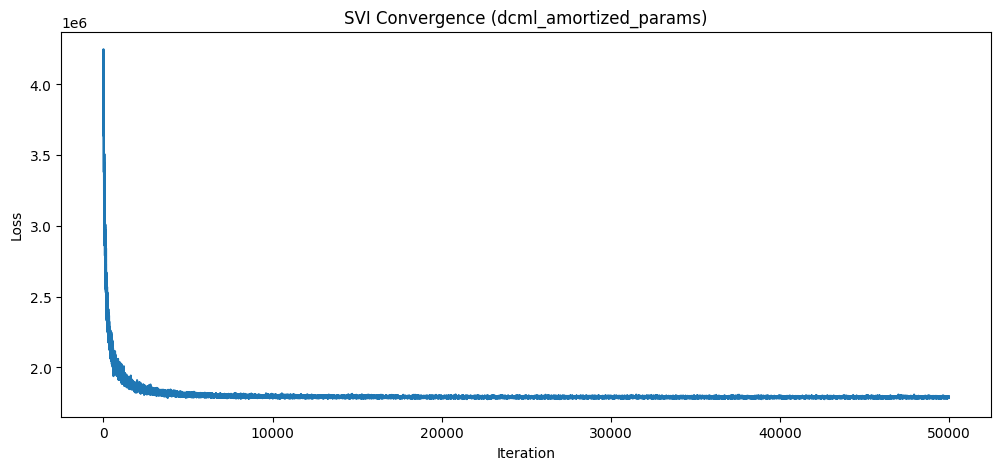

In [21]:
dcml_params, (alpha_h_history, alpha_phi_history) = infer_amortized_posteriors(npcs, len(dcml_chordtypes), dcml_obs,
                                                                              nsteps=50000, lr=0.01, plot_loss=True,
                                                                              save_as="dcml_amortized_params", collect_history=True
                                                                              )

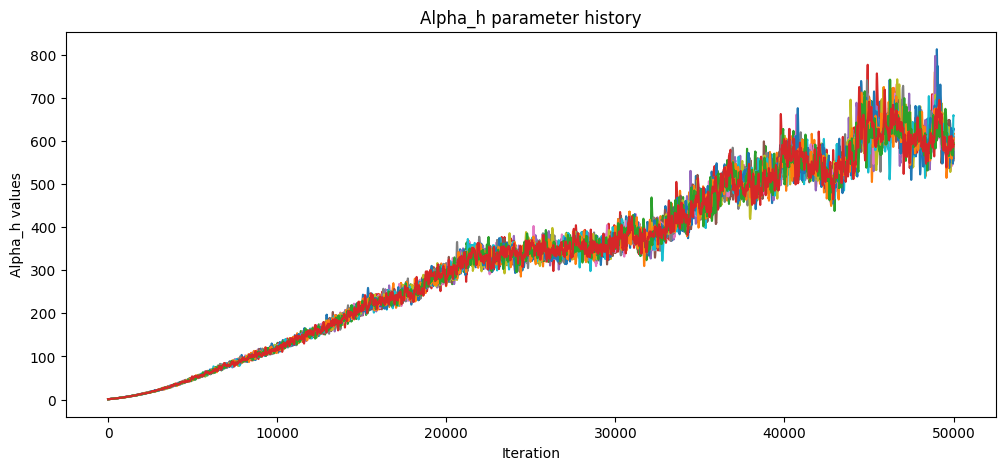

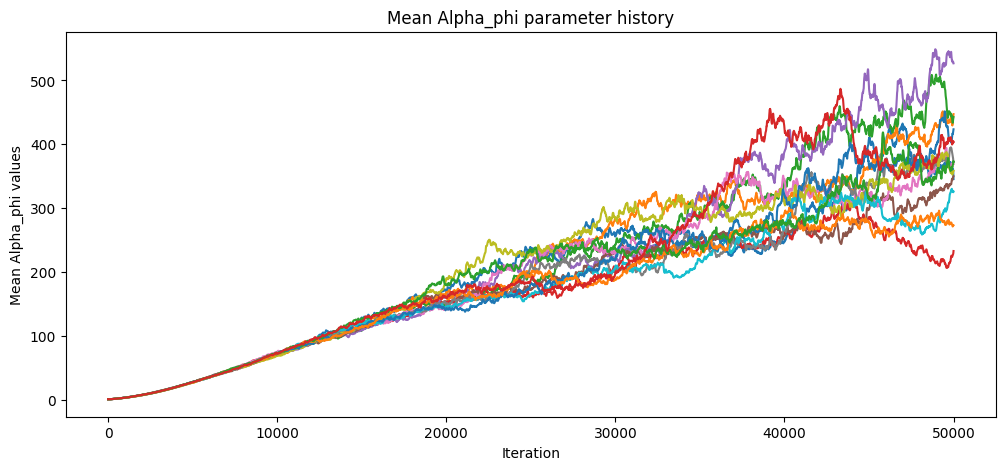

In [22]:
# Plot the parameter histories
plot_param_histories(alpha_h_history, alpha_phi_history)

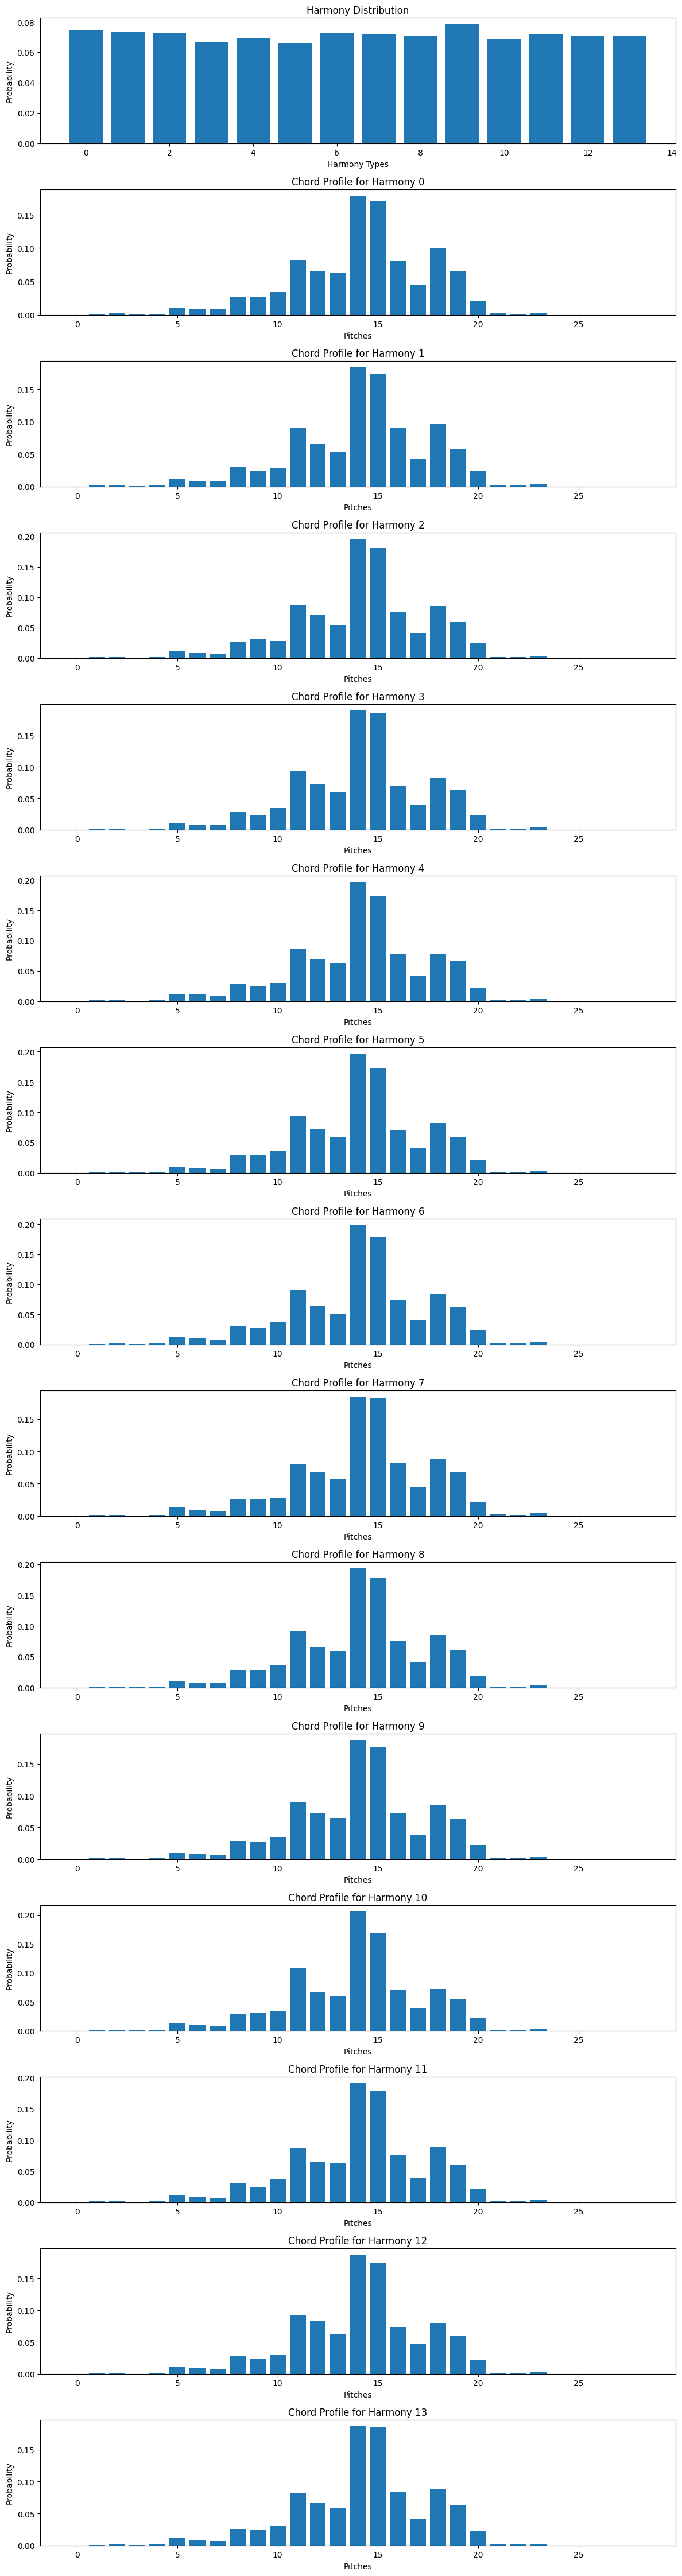

In [23]:
plot_amortized_inference_results(dcml_params, len(dcml_chordtypes), npcs, save_as="dcml_amortized_params")